# Live trade list quick PnL

Fill the variables below, then run.

rows: 37
portfolio_return: 0.0053195495036696926
return stats:
count    37.000000
mean      0.005320
std       0.010435
min      -0.011445
25%       0.000359
50%       0.003249
75%       0.009706
max       0.049804
Name: return, dtype: float64
all cbonds return stats:
count    377.000000
mean       0.005433
std        0.012872
min       -0.040299
25%       -0.000239
50%        0.003374
75%        0.009133
max        0.094113
dtype: float64
market_equal_weight_return: 0.005432562124047145


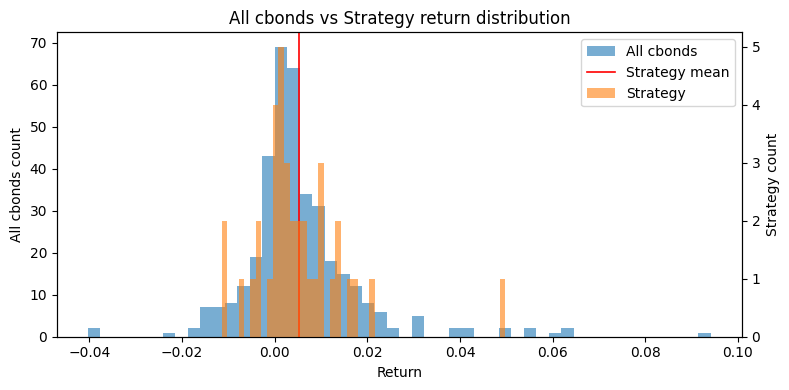

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---- settings ----
trade_day = '2026-01-22'  # trade_list date
signal_name = 'combo_default'
batch_id = 'Live'
results_root = Path('D:/cbond_daily/results')
cleaned_root = Path('D:/cbond_daily/clean_data')

buy_twap_col = 'twap_0945_1000'
sell_twap_col = 'twap_1430_1442'
twap_bps = 1.5
fee_bps = 0.7

# ---- load trade list ----
trade_dir = results_root / 'live' / trade_day / batch_id / signal_name
trade_path = trade_dir / 'trade_list.csv'
trades = pd.read_csv(trade_path)
trades['trade_date'] = pd.to_datetime(trades['trade_date']).dt.date

# ---- load cleaned data for trade_day ----
day = pd.to_datetime(trade_day).date()
month = f'{day.year:04d}-{day.month:02d}'
cleaned_path = cleaned_root / month / f'{day:%Y%m%d}.parquet'
df = pd.read_parquet(cleaned_path)

# ---- merge and compute return ----
merged = trades.merge(df[['code', buy_twap_col, sell_twap_col]], on='code', how='left')

def apply_bps(px, bps, side):
    if side == 'buy':
        return px * (1 + bps / 10000.0)
    return px * (1 - bps / 10000.0)

cost_bps = twap_bps + fee_bps
buy_px = apply_bps(merged[buy_twap_col], cost_bps, 'buy')
sell_px = apply_bps(merged[sell_twap_col], cost_bps, 'sell')
merged['return'] = (sell_px - buy_px) / buy_px

# ---- summary ----
merged['weight'] = merged.get('weight', 1.0 / len(merged))
merged['weight'] = merged['weight'].fillna(0.0)
port_ret = float((merged['return'] * merged['weight']).sum())
print('rows:', len(merged))
print('portfolio_return:', port_ret)

# ---- per-stock stats ----
stats = merged['return'].describe()
print('return stats:')
print(stats)


# ---- all cbonds return distribution ----
all_df = df[['code', buy_twap_col, sell_twap_col]].copy()
all_df = all_df[
    all_df[buy_twap_col].notna()
    & all_df[sell_twap_col].notna()
    & (all_df[buy_twap_col] > 0)
    & (all_df[sell_twap_col] > 0)
]
all_buy = apply_bps(all_df[buy_twap_col], cost_bps, 'buy')
all_sell = apply_bps(all_df[sell_twap_col], cost_bps, 'sell')
all_returns = (all_sell - all_buy) / all_buy

print('all cbonds return stats:')
print(all_returns.describe())

# equal-weight market return (all tradable)
if len(all_returns) > 0:
    market_eq_ret = float(all_returns.mean())
    print('market_equal_weight_return:', market_eq_ret)

# histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()
ax.hist(all_returns.dropna(), bins=50, alpha=0.6, label='All cbonds')
ax2.hist(merged['return'].dropna(), bins=50, alpha=0.6, color='tab:orange', label='Strategy')
ax.axvline(merged['return'].mean(), color='red', linewidth=1.2, label='Strategy mean')
ax.set_title('All cbonds vs Strategy return distribution')
ax.set_xlabel('Return')
ax.set_ylabel('All cbonds count')
ax2.set_ylabel('Strategy count')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')
fig.tight_layout()
plt.show()



In [2]:
merged

,trade_date,code,weight,twap_0945_1000,twap_1430_1442,return
0,2026-01-22,110099.SH,0.027027,147.1851,147.6152,0.002481
1,2026-01-22,111002.SH,0.027027,137.1987,139.1650,0.013886
2,2026-01-22,111003.SH,0.027027,139.0871,139.8338,0.004926
3,2026-01-22,111022.SH,0.027027,158.0142,158.8236,0.004680
4,2026-01-22,113037.SH,0.027027,109.9298,109.9946,0.000149
5,2026-01-22,113643.SH,0.027027,132.8770,133.2010,0.001997
6,2026-01-22,113652.SH,0.027027,140.5882,142.0390,0.009875
7,2026-01-22,113665.SH,0.027027,132.1792,134.0283,0.013543
8,2026-01-22,113671.SH,0.027027,144.3525,144.8853,0.003249
9,2026-01-22,113674.SH,0.027027,135.4359,136.6828,0.008763
